In [1]:
%gui qt

In [53]:
from importlib import reload
from pprint import pprint

import numpy as np
from matplotlib import pyplot as plt

import pyqtgraph as pg
from pyqtgraph.flowchart import Flowchart, Node as pgNode
from pyqtgraph import Qt
from pyqtgraph.Qt import QtGui, QtCore
from pyqtgraph.flowchart import library as fclib

In [3]:
def testdata_1d(nvals=11):
    x = np.linspace(0, 10, nvals)
    y = np.cos(x)
    z = np.cos(x)**2
    d = DataDict(
        x = {'values' : x},
        y = {'values' : y, 'axes' : ['x']},
        z = {'values' : z, 'axes' : ['x']},
    )
    return d

def testdata_3d(nx=3, ny=3, nz=3, rand_factor=1):
    x = np.linspace(0, 10, nx)
    y = np.linspace(-5, 5, ny)
    z = np.arange(nz)
    xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
    dd = np.cos(xx) * np.sin(yy) + rand_factor * np.random.rand(*zz.shape)
    dd2 = np.sin(xx) * np.cos(yy) + rand_factor * np.random.rand(*zz.shape)
    d = DataDict(
        x = dict(values=xx.reshape(-1), unit='mX'),
        y = dict(values=yy.reshape(-1), unit='kY'),
        z = dict(values=zz.reshape(-1), unit='MZ'),
        data = dict(values=dd.reshape(-1), axes=['x', 'y', 'z'], unit='OMFG'),
        more_data = dict(values=dd2.reshape(-1), axes=['x', 'y', 'z'], unit='WTF'),
        different_data = dict(values=dd2.T.reshape(-1), axes=['z', 'y', 'x'], unit='FML')
    )
    return d

In [99]:
from plottr.data import datadict; reload(datadict)
from plottr.data.datadict import togrid, DataDict, GridDataDict

from plottr.node import node; reload(node)
from plottr.node.node import Node, NodesWidget

from plottr.node import data_selector; reload(data_selector)
from plottr.node.data_selector import DataSelector

from plottr.node import xy_axes_selector; reload(xy_axes_selector)
from plottr.node.xy_axes_selector import DimensionReducer

# Simple DataSelector Test

# Combine DataSelector and DimensionReducer

In [100]:
def testdata_2d(nx=10, ny=10):
    x = np.linspace(0, 10, nx)
    y = np.arange(ny)
    
    xx, yy = np.meshgrid(x, y, indexing='ij')
    dd = np.cos(xx) + (-0.05 + 0.1 * np.random.rand(*yy.shape))
    dd2 = np.sin(xx) + (-0.5 + 1 * np.random.rand(*yy.shape))
    
    d = DataDict(
        x = dict(values=xx.reshape(-1)),
        y = dict(values=yy.reshape(-1)),
        cos_data = dict(values=dd.reshape(-1), axes=['x', 'y']),
        sin_data = dict(values=dd2.reshape(-1), axes=['x', 'y']),
    )
    return d

data_in = testdata_2d(21, 500)

In [101]:
Node.raiseExceptions = True
Node.debug = True
DataSelector.debug = True

nodelib = fclib.NodeLibrary()
nodelib.addNodeType(DataSelector, [('Basic')])
nodelib.addNodeType(DimensionReducer, [('Basic')])

fc = Flowchart(terminals={
    'dataIn': {'io': 'in'},
    'dataOut': {'io': 'out'}
})
fc.library = nodelib

selector = fc.createNode('DataSelector')
dim_reduce = fc.createNode('DimensionReducer')

fc.connectTerminals(fc['dataIn'], selector['dataIn'])
fc.connectTerminals(selector['dataOut'], dim_reduce['dataIn'])
fc.connectTerminals(dim_reduce['dataOut'], fc['dataOut'])

dialog = QtGui.QDialog()
nw = NodesWidget()
nw.addNodeWidget(selector, 'Data Selector')
layout = QtGui.QVBoxLayout(dialog)
layout.addWidget(nw)
dialog.show()

fc.setInput(dataIn=data_in)

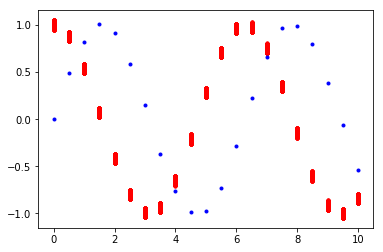

In [113]:
selector.grid = True
selector.selectedData = [
    'sin_data', 
    'cos_data',
]

dim_reduce.targetNames = ['sin_data']
dim_reduce.reductions = {
    'y' : (np.mean,),
}

data_out = fc.output()['dataOut']

fig, ax = plt.subplots(1,1)
_ = ax.plot(data_out['x']['values'], data_out['cos_data']['values'], 'r.')
_ = ax.plot(data_out['x']['values'], data_out['sin_data']['values'], 'b.')

In [115]:
# data_out